### Ali Sarraj, MTH 448, Project 6

## 🎼 Jazz or Metal? Bayes Picks 🎼

# Introduction

#### Have you ever wondered how shazam works? Have you ever wondered how spotify recommends music that is similar to your music taste? All of these things are possible because of two things: machine learning and audio analysis. We will be exploring both of these in this report through implementing a music genre classifier that will determine if a song's genre is either jazz or metal, using Bayes theorem.

### Bayes Theorem
>### P(A|B) = P(B|A) * P(A) / P(B)

#### Bayes Theorem is a powerful tool in the probability toolkit. It allows us to calculate the probability of an event based on prior knowledge of conditions that are related to the event. We will use it to determine the probability a song is either jazz or metal (more specifically, we will use Gaussian Naive Bayes, more on that later in the report). But how do we go about this? Well this is where audio analysis comes into play. We will examining what is called the 'features' of a soundwave, which are charateristics or properties of the wave.

## Key Features Include:

>### *Chroma:* a representation of the harmonic contents. Also can be thought of as the energy or intensity of a sound wave.
>
>### *Root Mean Square (RMS):* the average loudness of a wave.
>
>### *Spectral Centroid:* the center of mass or the balance of a signal. So if a song has more frequencies towards the end, it's spectral centroid will be towards the end. Whereas if it has a more even distribuition of frequencies, it's spectral centroid will be somewhere in the middle. It can be thought of as the average frequence of a sound spectrum.
>
>### *Spectral Bandwidth:* Also dealing with frequencies, this indicates how spread out the frequencies are along the sound spectrum. 
>
>### *Mel-Frequency Cepstral Coefficient (MFCC):* Arguably the most complex and least intuitive in this list, MFCC's are fundamental in any sound recoginition technology. They are coefficients that represent the spectral characteristics of an audio signal in the context of how humans percieve sound. They are computed using an algorithm which involves the Fourier transform to represent oscillating functions as summations, the Mel-Scale which represents the way humans percieve sound in pitch, and a number of other mathematical steps (more details can be found in the section for MFCC's in the sources at the end of this report). MFCC's are difficult to define, but reading through how they are computed can give somewhat of an understanding. But for our purposes, what we need to know is that they are multiple coefficients which capture unique characteristics in sound waves, and we will use 20 of them in the process of classifying the genre.
>
>### *Zero Crossing Rate:* the rate at which a soundwave changes signs (i.e the rate at which a wave changes from positive to negative.

#### Here are the features in our dataset:

| **Feature Name**               | **Feature Name**       |                                              
|-------------------------------|-------------------------|
| filename                      | rolloff_var             | 
| length                        | zero_crossing_rate_mean | 
| chroma_stft_mean              | harmony_mean            | 
| chroma_stft_var               | harmony_var             | 
| rms_mean                      | perceptr_mean           | 
| rms_var                       | perceptr_var            | 
| spectral_centroid_mean        | tempo                   | 
| spectral_centroid_var         | mfcc1_mean to mfcc20_mean | 
| spectral_bandwidth_mean       | mfcc1_var to mfcc20_var | 
| spectral_bandwidth_var        | label                   | 

#### As you can see, we have both the mean and variance of some of these features.

# (1) Preparing the data

In [4]:
import numpy as np 
import pandas as pd

In [5]:
music_data = pd.read_csv('file.csv') 
# Source of this data: https://www.geeksforgeeks.org/music-genre-classifier-using-machine-learning/

In [6]:
music_data

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


**In the scope of this report, we will only be focusing on the audio data of jazz and metal songs**

In [7]:
metal_data = music_data[music_data['label']=='metal']
jazz_data = music_data[music_data['label']=='jazz']

In [8]:
jazz_metal_data = pd.concat([metal_data, jazz_data], ignore_index=True)
jazz_metal_data

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,metal.00000.wav,661504,0.487716,0.067452,0.116125,0.000303,3274.488271,268188.963109,2722.524604,151283.782074,...,47.402462,-4.485988,41.050411,4.707357,36.572578,-2.754580,44.846279,0.499856,37.089111,metal
1,metal.00001.wav,661504,0.476903,0.071958,0.097298,0.000218,2922.845195,183896.529457,2620.939220,49910.397474,...,37.298557,-9.028761,37.896343,5.506845,34.330849,-6.194880,43.079819,3.124241,40.535103,metal
2,metal.00002.wav,661504,0.432415,0.074974,0.132810,0.000639,2198.918006,146483.728013,2006.406468,81102.756463,...,35.706135,-3.469525,33.916672,6.570201,38.387115,-6.574109,40.787182,2.962940,33.577770,metal
3,metal.00003.wav,661504,0.487554,0.078893,0.150183,0.000851,2752.264617,155540.402763,2205.786688,29377.697089,...,39.496056,-6.667662,39.869370,5.282710,50.354977,-2.324664,41.388176,3.579682,41.606361,metal
4,metal.00004.wav,661504,0.634766,0.048010,0.063476,0.000107,3403.073174,267804.428424,2825.134867,53354.067018,...,36.831020,-6.623356,39.403965,4.545003,32.381054,-4.264578,30.510605,4.288738,32.458736,metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,jazz.00095.wav,661794,0.311235,0.090341,0.068182,0.000695,1854.556905,214524.362274,2215.592498,126407.713980,...,92.108276,-5.153530,75.903023,3.057607,89.085808,2.093325,91.776138,0.951933,97.158752,jazz
196,jazz.00096.wav,661794,0.298770,0.093177,0.044420,0.000463,1873.833302,514803.821961,2083.706520,178343.209879,...,166.871582,1.778867,101.444366,-2.124144,47.913990,-5.369799,141.946411,-5.330001,129.295364,jazz
197,jazz.00097.wav,661794,0.224049,0.091032,0.021187,0.000184,1176.181446,245931.153143,1753.640845,186895.362068,...,170.751541,7.966308,171.086014,5.073698,136.068344,1.616789,110.436943,-4.366201,103.683487,jazz
198,jazz.00098.wav,661794,0.327593,0.091018,0.060162,0.000455,1885.601099,299907.045244,2230.789208,106215.474174,...,36.059933,-6.207161,33.550941,0.873401,40.771870,-3.393118,57.267189,-0.377289,62.587696,jazz


**Finally, let's split the data**

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = jazz_metal_data[['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'zero_crossing_rate_mean',
                    'spectral_centroid_mean', 'spectral_centroid_var', 
                     'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                     'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean',
                     'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean', 
                     'mfcc13_mean', 'mfcc14_mean', 'mfcc15_mean', 'mfcc16_mean', 'mfcc17_mean', 'mfcc18_mean', 
                     'mfcc19_mean', 'mfcc20_mean', 'mfcc1_var', 'mfcc2_var', 'mfcc3_var', 'mfcc4_var', 'mfcc5_var', 'mfcc6_mean',
                     'mfcc7_var', 'mfcc8_var', 'mfcc9_var', 'mfcc10_var', 'mfcc11_var', 'mfcc12_var', 
                     'mfcc13_var', 'mfcc14_var', 'mfcc15_var', 'mfcc16_var', 'mfcc17_var', 'mfcc18_var', 
                     'mfcc19_var', 'mfcc20_var'
                    ]] # features we will use to predict
y = jazz_metal_data['label'] # what we want to predict
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,train_size=0.8,random_state=42)

In [11]:
y_train

79     metal
197     jazz
38     metal
24     metal
122     jazz
       ...  
106     jazz
14     metal
92     metal
179     jazz
102     jazz
Name: label, Length: 160, dtype: object

In [12]:
X_train

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,zero_crossing_rate_mean,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,mfcc1_mean,...,mfcc11_var,mfcc12_var,mfcc13_var,mfcc14_var,mfcc15_var,mfcc16_var,mfcc17_var,mfcc18_var,mfcc19_var,mfcc20_var
79,0.472406,0.072405,0.127426,0.001773,0.143855,2710.543163,247566.872819,2264.313137,67836.501295,-74.863525,...,51.187180,52.269962,44.703156,62.630909,44.589798,56.555176,46.166824,58.300758,58.261131,35.421535
197,0.224049,0.091032,0.021187,0.000184,0.039908,1176.181446,245931.153143,1753.640845,186895.362068,-413.619934,...,64.069862,68.067657,86.268089,78.235191,106.239655,170.751541,171.086014,136.068344,110.436943,103.683487
38,0.470393,0.088615,0.145966,0.006987,0.148258,2690.658580,477449.802953,2118.668126,189899.237983,-122.093590,...,58.306747,143.268173,48.376099,85.197449,52.796028,49.142635,34.763046,49.655735,49.411339,39.056583
24,0.478725,0.074181,0.231532,0.000826,0.128289,2410.798727,211062.009117,2227.636452,66046.422335,-16.679001,...,48.715645,40.379494,48.037106,60.851761,42.269505,45.879524,47.675831,42.539852,44.008137,53.147888
122,0.201518,0.087061,0.050507,0.000736,0.051224,1451.871047,183845.292300,1920.376507,123995.412755,-298.757355,...,111.873718,126.349480,120.745239,112.576508,140.283035,190.724457,199.492020,224.265778,185.274475,153.708298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.274877,0.092139,0.098625,0.001363,0.048040,1219.493013,265266.655037,1459.066150,139164.059284,-234.359192,...,103.640900,65.915970,55.423218,56.352577,57.276573,56.547768,59.181240,105.146896,149.450302,132.899658
14,0.552626,0.063166,0.077597,0.000233,0.185252,2877.389184,93978.973918,2101.273063,34318.247843,-117.856339,...,29.716490,51.260502,28.556358,48.515114,40.318119,42.885750,25.299477,50.587223,30.784739,55.720436
92,0.341908,0.089214,0.166334,0.001421,0.093286,2089.971058,171318.624683,2065.151009,72667.884495,-67.878250,...,48.517197,45.190464,38.472031,37.212658,37.569794,44.888958,40.883896,41.816559,43.212715,50.191994
179,0.338348,0.084579,0.069850,0.000386,0.107845,2634.043030,360908.946788,2728.240133,118663.560223,-163.530350,...,73.536125,86.569687,95.207787,73.301620,82.519791,95.797638,98.465599,61.105072,68.589348,93.788239


**Note: here we already have the data of the features in the audio files, but typically in when analyzing sound waves, you can use a python library like librosa to extract all these features just from a .WAV file.**

# (2) Visuallizing Data

In [10]:
import matplotlib.pyplot as plt 
import librosa.display

**So now that we have our data, what does it really look like? We can use librosa to visualize the soundwaves**

**This is the wave of one of the metal songs**

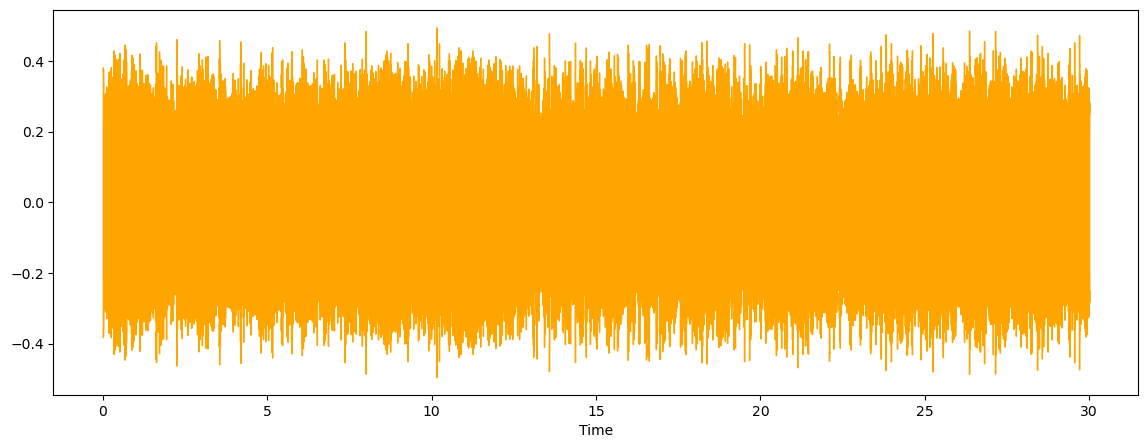

In [11]:
metal_path = 'genres_original/metal/' + jazz_metal_data['filename'].loc[0]
plt.figure(figsize=(14, 5)) 
x, sr = librosa.load(metal_path) 
librosa.display.waveshow(x, sr=sr,color='orange') 

**This is the wave of one of the jazz songs**

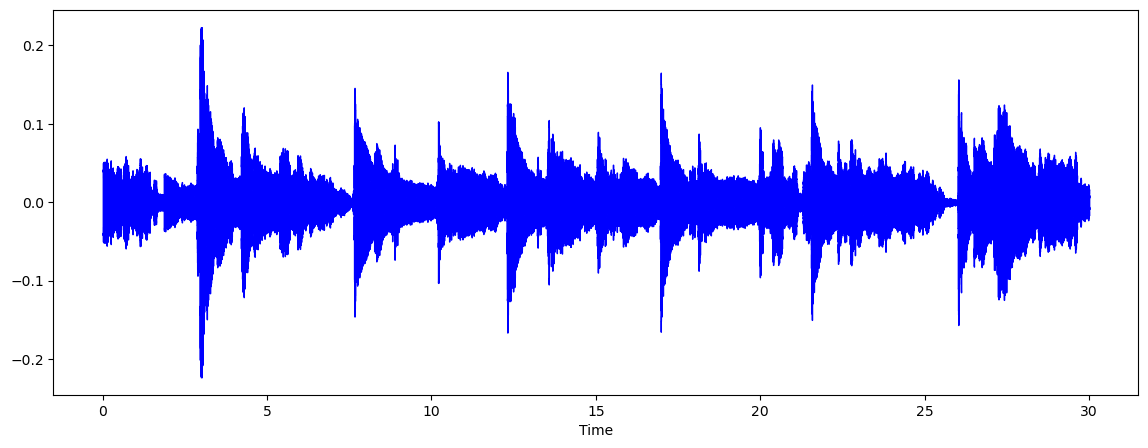

In [12]:
jazz_path = 'genres_original/jazz/' + jazz_metal_data['filename'].loc[197]
plt.figure(figsize=(14, 5)) 
x, sr = librosa.load(jazz_path) 
librosa.display.waveshow(x, sr=sr,color='blue') 

**Immediately, the difference is visible. The metal song has much more sustained loudness, whereas the jazz song is more rythmic and bumpy. We can test our knowledge on the key soundwave features. Remember RMS is the average loudness of a soundwave, so let's see what the RMS mean's of these songs are.**

In [13]:
jazz_song_rms_mean = jazz_metal_data['rms_mean'].loc[197]
jazz_song_rms_mean

0.0211866870522499

In [14]:
metal_song_rms_mean = jazz_metal_data['rms_mean'].loc[0]
metal_song_rms_mean

0.1161254942417144

**The metal song has a higher RMS mean. That makes sense and matches what the soundwave shows us.**

# (3) Classifying Genre

### Bayes Formula:
>### P(A|B) = P(B|A) * P(A) / P(B)

## Gaussian Naive Bayes

#### We now will begin classifying the data using Gaussian Naive Bayes. Gaussian Naive Bayes (GNB) is a machine learning algorithm that belongs to a family of Naive Bayes Classifiers. These classifiers all have a basis in Bayes theorem, but what makes them distinct is that they use Bayes theorem to classify data based on the probabilties of multiple features in the data. This makes them efficient for high-dimensional data.

### Here is the formula:

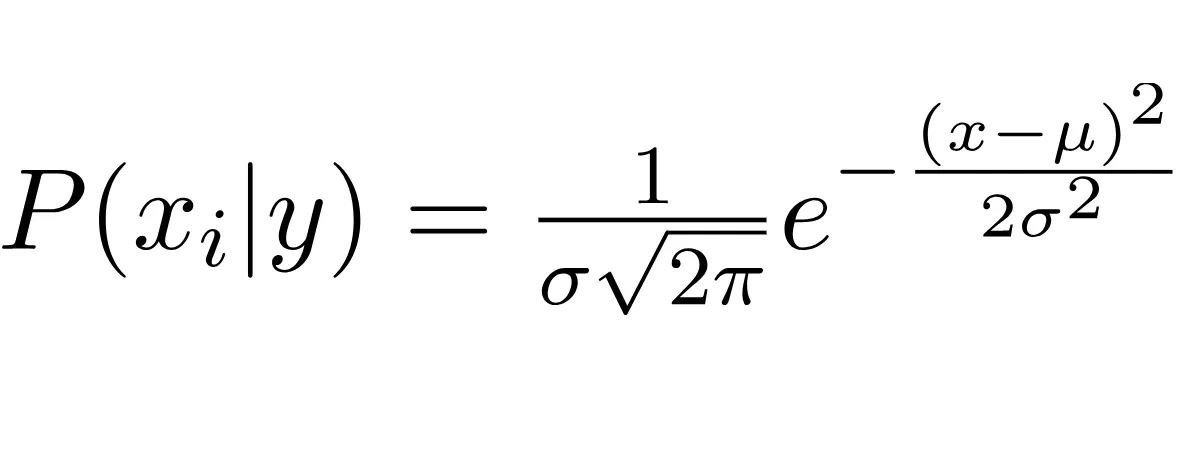

**As you can notice, this formula involves the mean (µ) and variance (σ). This is because the GNB algorithm assumes the features in the dataset are normally distributed, and this assumption simplifies the process of calculating probabilites. Instead of estimating the whole probability distribution, this algorithm only needs to estimate the mean and variance.**

**It's important to mention a subtle point so there is no confusion. The mean and variance we are talking about in regards to the GNB algorithm is not the same mean and variance of the features in our dataset (e.g rms_mean, rms_var, chroma_stft_mean, chroma_stft_var, etc...). In fact, what will essentially happen when we use GNB is that we will be taking the mean and variance, of those means and variances in our dataset. Those means and variances are simply features that represent the characteristics of a sound wave, they are not related to the mean and variance in GNB.**

**Essentially, every xᵢ in the formula above will be one of the key features or properties of the soundwaves we discussed in the introduction. Sklearns has an implementation of GNB we will use.**

In [13]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB() # GaussianNB classifer

In [14]:
gnb.fit(X_train, y_train) # using our training data to train the model

GaussianNB()

**Now, let's make predictions through our model. And then we will test the accuracy of those predictions.**

In [15]:
predictions = gnb.predict(X_test) # predicted lables of genres

In [16]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions) 
accuracy

0.925

**Very high accuracy score! Our classifier is pretty successful.**

**So, we can actually write a function that can extract these features with librosa. Once we extract those features, we can then use it to predict the genre.**

In [49]:
def extract_features(WAV_filename):
    audio_data, sr = librosa.load(WAV_filename, sr=None) # loading file
    
    # ..Extracting features..
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    rms = librosa.feature.rms(y=audio_data)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=20)
    
    # Dictionary containing all the features
    features = { 
        'chroma_stft_mean': np.mean(chroma_stft), 
        'chroma_stft_var': np.var(chroma_stft),
        'rms_mean': np.mean(rms), 'rms_var': np.var(rms),
        'zero_crossing_rate_mean': np.mean(zcr),
        'spectral_centroid_mean': np.mean(spectral_centroid), 
        'spectral_centroid_var': np.var(spectral_centroid),
        'spectral_bandwidth_mean': np.mean(spectral_bandwidth), 
        'spectral_bandwidth_var': np.var(spectral_bandwidth),
    }

    # Add MFCC means and vars
    for i in range(20):
        features[f'mfcc{i+1}_mean'] = np.mean(mfcc[i])
        features[f'mfcc{i+1}_var'] = np.var(mfcc[i])
    
    features_df = pd.DataFrame([features])
    return features_df

**Now, we can test our function and the GNB prediction. Here we have the WAV file of a jazz song.**

In [50]:
WAV_file = 'Albert_Beger_Shasha.wav'

In [52]:
features = extract_features(WAV_file)
features = features[X_train.columns] # ordering columns
features 

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,zero_crossing_rate_mean,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,mfcc1_mean,...,mfcc11_var,mfcc12_var,mfcc13_var,mfcc14_var,mfcc15_var,mfcc16_var,mfcc17_var,mfcc18_var,mfcc19_var,mfcc20_var
0,0.367939,0.091438,0.101552,0.004012,0.059471,2440.543031,725627.723969,2658.147358,727935.543056,-211.743561,...,92.726509,68.616379,75.398277,86.050766,71.801659,60.359287,68.895935,64.89106,67.783081,74.805466


In [54]:
prediction = gnb.predict(features)
prediction[0]

'jazz'

**It was correct! Our classifier is functional in predicting jazz or metal songs, but how about we expand it and see if it's capable of multiple genres.**

# (4) Classifying multiple genres

**Here's our original music dataframe**

In [19]:
music_data

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [20]:
X = music_data[['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'zero_crossing_rate_mean',
                    'spectral_centroid_mean', 'spectral_centroid_var', 
                     'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                     'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean',
                     'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean', 
                     'mfcc13_mean', 'mfcc14_mean', 'mfcc15_mean', 'mfcc16_mean', 'mfcc17_mean', 'mfcc18_mean', 
                     'mfcc19_mean', 'mfcc20_mean', 'mfcc1_var', 'mfcc2_var', 'mfcc3_var', 'mfcc4_var', 'mfcc5_var', 'mfcc6_mean',
                     'mfcc7_var', 'mfcc8_var', 'mfcc9_var', 'mfcc10_var', 'mfcc11_var', 'mfcc12_var', 
                     'mfcc13_var', 'mfcc14_var', 'mfcc15_var', 'mfcc16_var', 'mfcc17_var', 'mfcc18_var', 
                     'mfcc19_var', 'mfcc20_var'
                    ]] # features we will use to predict
y = music_data['label'] # what we want to predict
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,train_size=0.8,random_state=42)

In [28]:
gnb.fit(X_train, y_train)

GaussianNB()

In [22]:
predictions = gnb.predict(X_test) # predicted lables of genres
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions) 
accuracy

0.455

**The accuracy dropped signifcantly. Jazz and metal songs are very distinct from each other, but now that we added the possibility of multiple other genres that are sonically more similar to jazz or metal, the line becomes more blurry.**

# Conclusion

### Our classifier was effective when considering two genres, but when we expand the possibilities to many genres, the classifier was less effective. There are things we can do in the stage of preprocessing data to improve the accuracy, but in general, for classification of multiple genres, there might be more effecitive algorithms than GNB.

### But that does lead to a question in music genre classification, how precise can algorithms we write be? Music genres continually grow and evolve, as well as subgenres of those genres. There are some genres that have a clear distinction, like jazz and metal, but there also many genres where the line is much more blurry. Our definitions of genres can be loose. Looking at the history of music, there have been many artists who've bent a genre a certain way, so much that it does not sound like the original genre, but still falls under that category. The Beatles' "Tomorrow Never Knows" is an example.

### So when there are disagreements in how we define certain genres, or more specifically, what makes a song fall under a certain genre, the question becomes – how effective of algorithms can we truly write to classify these genres? If the algorithms we write are always built from how we define things, then maybe as we have more concise and clear defintions, we can write more effective algorithms.

## Sources Used:
### For features of soundwaves:
#### https://www.geeksforgeeks.org/automated-music-genre-classification-using-librosa-and-xgboost/
#### https://farzanaanjum.medium.com/music-genre-classification-with-python-51bff77adfd6
#### https://medium.com/@goksselgunduz/fundamental-terms-of-signal-processing-2826a1b5543d
#### https://majormixing.com/what-is-rms-in-audio-world/

### For MFCC's:
#### https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779
#### https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/#role-of-melfrequency-cepstral-coefficients-mfccs
#### https://www.youtube.com/watch?v=4_SH2nfbQZ8&ab_channel=ValerioVelardo-TheSoundofAI

### For Gaussian naive bayes and the machine learning process:
#### https://www.geeksforgeeks.org/music-genre-classifier-using-machine-learning/
#### https://www.geeksforgeeks.org/naive-bayes-classifiers/

#### https://www.geeksforgeeks.org/gaussian-naive-bayes-using-sklearn/

#### https://medium.com/@kashishdafe0410/gaussian-naive-bayes-understanding-the-basics-and-applications-52098087b963